In [ ]:
# -------------------------------------------
# Task 4: In-Sample Evaluation
# Question: Using the entire sample data up to each time t, compute optimal portfolio weights using different portfolio strategies
# (Mean-Variance (MV), No Short Selling Mean-Variance (NSMV), and Minimum Investment Mean-Variance (MIMV)).
# Evaluate their performance using realized returns at time t+1.
# Dataset: Average Value-Weighted Returns (Monthly)
# -------------------------------------------

# Step 0: Import Required Libraries
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from google.colab import files  # Required for Google Colab to upload files

# -------------------------------------------
# Step 1: Data Loading and Preparation
print("Please upload your 'Average Value-Weighted Returns (Monthly).csv' file:")
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Step 2: Read CSV (skip metadata rows, read only the data portion)
portfolio_data = pd.read_csv(filename, skiprows=20, nrows=419)

# Step 3: Clean and Parse Date Column
portfolio_data.iloc[:, 0] = portfolio_data.iloc[:, 0].astype(str).str.strip()
portfolio_data.iloc[:, 0] = pd.to_datetime(portfolio_data.iloc[:, 0], format='%Y%m', errors='coerce')
portfolio_data.dropna(subset=[portfolio_data.columns[0]], inplace=True)
portfolio_data.set_index(portfolio_data.columns[0], inplace=True)

# Step 4: Clean Data - Convert to Numeric, Handle Missing Values
portfolio_data = portfolio_data.apply(pd.to_numeric, errors='coerce')
portfolio_data.replace(-99.99, np.nan, inplace=True)

print("\nMissing values per column after initial cleaning:\n", portfolio_data.isna().sum())
print("Total missing values in dataset after initial cleaning:", portfolio_data.isna().sum().sum())

portfolio_data.dropna(inplace=True)

print("\nShape of data after dropping missing values:", portfolio_data.shape)
print("First 5 rows of cleaned data:\n", portfolio_data.head())

# -------------------------------------------
# Step 5: Compute Mean and Covariance Matrix (on entire sample - static throughout loop)
mean_returns = portfolio_data.mean() / 100  # Convert from percentage to decimal
cov_matrix = portfolio_data.cov() / (100 ** 2)  # Convert from percentage squared to decimal

print("\nMean Returns:\n", mean_returns)
print("\nCovariance Matrix:\n", cov_matrix)

# -------------------------------------------
# Step 6: Optimization Setup
mean_asset_returns = mean_returns.values
covariance_matrix = cov_matrix.values
num_assets = len(mean_asset_returns)

# Define a target expected return (average across assets)
target_expected_return = mean_asset_returns.mean()
print(f"\nChosen Target Return: {target_expected_return:.4f}")

# Objective Function: Minimize Portfolio Variance
def portfolio_variance(weights, covariance_matrix):
    return weights.T @ covariance_matrix @ weights

# Start with equal weights
initial_weights = np.ones(num_assets) / num_assets

# Containers to store weights and realized returns over time
optimal_weights_mv = []       # Mean-Variance (MV) portfolio
optimal_weights_nsmv = []     # No Short-Selling Mean-Variance (NSMV)
optimal_weights_mimv = []     # Min Investment Mean-Variance (MIMV)

realized_returns_mv = []      # MV realized returns at t+1
realized_returns_nsmv = []    # NSMV realized returns at t+1
realized_returns_mimv = []    # MIMV realized returns at t+1

# -------------------------------------------
# Step 7: Rolling Optimization Over Time (In-Sample Evaluation)
# At each time t, use returns data up to t (inclusive) to compute optimal weights
for t in range(len(portfolio_data) - 1):
    # In-sample data up to time t
    returns_t = portfolio_data.iloc[:t+1]

    # For now, using full-sample mean and covariance (can be updated for rolling window)
    mean_returns_t = mean_returns
    cov_matrix_t = cov_matrix

    # Common constraints for all portfolios:
    # 1. Portfolio weights sum to 1
    # 2. Portfolio meets target expected return
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: w @ mean_returns_t - target_expected_return}
    ]

    # --- MV (Mean-Variance Portfolio) - allows short selling (no bounds)
    res_mv = minimize(
        portfolio_variance,
        initial_weights,
        args=(cov_matrix_t,),
        method='SLSQP',
        constraints=constraints,
        bounds=None
    )
    weights_mv = res_mv.x if res_mv.success else initial_weights  # fallback if optimization fails

    # --- NSMV (No Short Selling) - weights >= 0
    bounds_nsmv = [(0, None)] * num_assets
    res_nsmv = minimize(
        portfolio_variance,
        initial_weights,
        args=(cov_matrix_t,),
        method='SLSQP',
        constraints=constraints,
        bounds=bounds_nsmv
    )
    weights_nsmv = res_nsmv.x if res_nsmv.success else initial_weights

    # --- MIMV (Min Investment Constraint) - weights >= 1/(2N)
    min_weight = 1 / (2 * num_assets)
    bounds_mimv = [(min_weight, 1)] * num_assets
    res_mimv = minimize(
        portfolio_variance,
        initial_weights,
        args=(cov_matrix_t,),
        method='SLSQP',
        constraints=constraints,
        bounds=bounds_mimv
    )
    weights_mimv = res_mimv.x if res_mimv.success else initial_weights

    # Store the optimal weights for each strategy
    optimal_weights_mv.append(weights_mv)
    optimal_weights_nsmv.append(weights_nsmv)
    optimal_weights_mimv.append(weights_mimv)

    # Compute and store realized return at t+1 using weights from time t
    returns_next = portfolio_data.iloc[t+1].values / 100  # Convert from % to decimal
    realized_returns_mv.append(weights_mv @ returns_next)
    realized_returns_nsmv.append(weights_nsmv @ returns_next)
    realized_returns_mimv.append(weights_mimv @ returns_next)

# -------------------------------------------
# Step 8: Compile and Summarize Results

# Create DataFrame of realized portfolio returns
portfolio_returns_df = pd.DataFrame({
    'MV_Returns': realized_returns_mv,
    'NSMV_Returns': realized_returns_nsmv,
    'MIMV_Returns': realized_returns_mimv
}, index=portfolio_data.index[1:])  # Skip first row (t=0 has no t+1 return)

# Match the index for weights with the number of computed weights
valid_index = portfolio_data.index[1:1 + len(optimal_weights_mv)]

# Convert list of weights to DataFrames with correct index
weights_df_mv = pd.DataFrame(optimal_weights_mv, index=valid_index)
weights_df_nsmv = pd.DataFrame(optimal_weights_nsmv, index=valid_index)
weights_df_mimv = pd.DataFrame(optimal_weights_mimv, index=valid_index)

# Label weight columns by asset name
weights_df_mv.columns = portfolio_data.columns
weights_df_nsmv.columns = portfolio_data.columns
weights_df_mimv.columns = portfolio_data.columns

# Display weight matrices and return statistics
print("\nFirst few rows of MV Optimal Weights:")
print(weights_df_mv.head())

print("\nFirst few rows of NSMV Optimal Weights:")
print(weights_df_nsmv.head())

print("\nFirst few rows of MIMV Optimal Weights:")
print(weights_df_mimv.head())

# Summary statistics of realized returns (mean, std, min, max, etc.)
print("\nSummary statistics for realized portfolio returns:")
print(portfolio_returns_df.describe())

# Show first few rows of the return time series
print("\nFirst few rows of realized portfolio returns:")
print(portfolio_returns_df.head())


Please upload your 'Average Value-Weighted Returns (Monthly).csv' file:


Saving Developed_25_Portfolios_ME_BE-ME.csv to Developed_25_Portfolios_ME_BE-ME (4).csv

Missing values per column after initial cleaning:
 SMALL LoBM    0
ME1 BM2       0
ME1 BM3       0
ME1 BM4       0
SMALL HiBM    0
ME2 BM1       0
ME2 BM2       0
ME2 BM3       0
ME2 BM4       0
ME2 BM5       0
ME3 BM1       0
ME3 BM2       0
ME3 BM3       0
ME3 BM4       0
ME3 BM5       0
ME4 BM1       0
ME4 BM2       0
ME4 BM3       0
ME4 BM4       0
ME4 BM5       0
BIG LoBM      0
ME5 BM2       0
ME5 BM3       0
ME5 BM4       0
BIG HiBM      0
dtype: int64
Total missing values in dataset after initial cleaning: 0

Shape of data after dropping missing values: (417, 25)
First 5 rows of cleaned data:
             SMALL LoBM  ME1 BM2  ME1 BM3  ME1 BM4  SMALL HiBM  ME2 BM1  \
                                                                         
1990-07-01        1.14     1.31     1.27     1.44       -0.14     2.10   
1990-08-01      -10.67   -12.07   -10.34    -9.47       -9.89   -12.51   
1990-0

/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)



First few rows of MV Optimal Weights:
            SMALL LoBM   ME1 BM2  ME1 BM3   ME1 BM4  SMALL HiBM   ME2 BM1  \
                                                                            
1990-08-01    0.449387  0.079158 -0.09085  0.295922    0.190984 -0.131296   
1990-09-01    0.449387  0.079158 -0.09085  0.295922    0.190984 -0.131296   
1990-10-01    0.449387  0.079158 -0.09085  0.295922    0.190984 -0.131296   
1990-11-01    0.449387  0.079158 -0.09085  0.295922    0.190984 -0.131296   
1990-12-01    0.449387  0.079158 -0.09085  0.295922    0.190984 -0.131296   

             ME2 BM2   ME2 BM3   ME2 BM4   ME2 BM5  ...   ME4 BM1   ME4 BM2  \
                                                    ...                       
1990-08-01 -0.246538  0.216155  0.225241  0.113796  ... -0.508058  0.143302   
1990-09-01 -0.246538  0.216155  0.225241  0.113796  ... -0.508058  0.143302   
1990-10-01 -0.246538  0.216155  0.225241  0.113796  ... -0.508058  0.143302   
1990-11-01 -0.246538  0.21

In [ ]:
# ----------------------------- Task 5 -----------------------------
# Question:
# For the out-of-sample evaluation proceed as follows:
# At every possible time t, use the data of the previous M periods to estimate the mean and covariance matrix of returns
# using the unbiased sample estimator for the mean and covariance matrix. Use these estimates as inputs for the
# respective single-period mean-variance portfolio optimization problem corresponding to NSMV, MV, and MIMV with the same
# expected return constraint as in the in-sample evaluation. Solve this problem to determine the optimal portfolio at time t.
# Compute the return obtained by this portfolio in the investment period from t to t+1.
# -----------------------------------------------------------------

# ----------------------------- Libraries -----------------------------
import numpy as np                             # Import numpy for numerical operations
import pandas as pd                            # Import pandas for data handling
from scipy.optimize import minimize           # Import minimize for optimization problems
from google.colab import files                 # Import files for uploading files in Colab
# ---------------------------------------------------------------------

# ----------------------------- Data Loading & Preparation -----------------------------
print("Please upload your 'Average Value-Weighted Returns (Monthly).csv' file:")  # Prompt user to upload data file
uploaded = files.upload()                        # Upload file from local system
filename = list(uploaded.keys())[0]              # Get the filename uploaded

portfolio_data = pd.read_csv(filename, skiprows=20, nrows=419)  # Read CSV skipping first 20 rows, read 419 rows
portfolio_data.iloc[:, 0] = portfolio_data.iloc[:, 0].astype(str).str.strip()  # Convert first column to string and strip spaces
portfolio_data.iloc[:, 0] = pd.to_datetime(portfolio_data.iloc[:, 0], format='%Y%m', errors='coerce')  # Convert first column to datetime, format YYYYMM
portfolio_data.dropna(subset=[portfolio_data.columns[0]], inplace=True)       # Drop rows where date conversion failed (NaT)
portfolio_data.set_index(portfolio_data.columns[0], inplace=True)              # Set first column (date) as index

portfolio_data = portfolio_data.apply(pd.to_numeric, errors='coerce')          # Convert all other columns to numeric, coercing errors to NaN
portfolio_data.replace(-99.99, np.nan, inplace=True)                           # Replace all -99.99 values with NaN as missing values

print("\nMissing values per column after initial cleaning:\n", portfolio_data.isna().sum())  # Print count of missing values per column
print("Total missing values in dataset after initial cleaning:", portfolio_data.isna().sum().sum())  # Print total missing values in dataset

portfolio_data.dropna(inplace=True)                                             # Drop all rows with any missing values

print("\nShape of data after dropping missing values:", portfolio_data.shape)     # Print shape of cleaned dataset
print("First 5 rows of cleaned data:\n", portfolio_data.head())                  # Print first 5 rows for quick look
# ---------------------------------------------------------------------

# ----------------------------- Parameters & Helper Functions -----------------------------
num_assets = portfolio_data.shape[1]                     # Number of assets (columns)
initial_weights = np.ones(num_assets) / num_assets       # Initialize weights equally for all assets
target_expected_return = 0.0070                           # Set target expected return (0.7%) as constraint

def portfolio_variance(weights, cov_matrix):             # Define function to calculate portfolio variance
    """Calculate portfolio variance given weights and covariance matrix."""
    return weights.T @ cov_matrix @ weights              # Compute quadratic form: w' * Σ * w
# ---------------------------------------------------------------------

# ----------------------------- Out-of-Sample Evaluation -----------------------------
estimation_window = 60                                   # Set estimation window M to 60 months (5 years)
results = {}                                            # Initialize dictionary to store results for different M

# Create empty DataFrames to store weights for each portfolio strategy at each time t
weights_mv_df = pd.DataFrame(columns=portfolio_data.columns)    # For MV portfolio
weights_nsmv_df = pd.DataFrame(columns=portfolio_data.columns)  # For NSMV portfolio (no short-selling)
weights_mimv_df = pd.DataFrame(columns=portfolio_data.columns)  # For MIMV portfolio (minimum investment per asset)

# Lists to store out-of-sample returns for each portfolio strategy
oos_returns_mv = []                                      # MV returns
oos_returns_nsmv = []                                    # NSMV returns
oos_returns_mimv = []                                    # MIMV returns

print("\n--- Starting Out-of-Sample Evaluation ---")   # Inform user process is starting
print(f"\nProcessing for estimation window: {estimation_window} months...")  # Print current estimation window

# Loop over all possible times t from M to end-1 (to get t+1 returns)
for i, t in enumerate(range(estimation_window, len(portfolio_data) - 1)):

    # ----------------------------- Extract rolling window data -----------------------------
    data_window = portfolio_data.iloc[t - estimation_window : t]              # Get previous M months data up to time t (exclusive)

    # ----------------------------- Estimate mean returns and covariance -----------------------------
    mean_returns_t = data_window.mean().values / 100                          # Calculate unbiased mean returns, convert from % to decimal
    cov_matrix_t = data_window.cov().values / (100 ** 2)                      # Calculate covariance matrix, convert from %^2 to decimal^2

    if i < 5:  # Print first 5 iterations for debugging/verification
        print(f"\nTime t = {portfolio_data.index[t].strftime('%Y-%m-%d')}")   # Show current time index
        print("Estimated mean returns vector:")                             # Print mean returns vector
        print(pd.Series(mean_returns_t, index=portfolio_data.columns))
        print("\nEstimated covariance matrix:")                             # Print covariance matrix
        print(pd.DataFrame(cov_matrix_t, index=portfolio_data.columns, columns=portfolio_data.columns))

    # ----------------------------- Define constraints -----------------------------
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},                      # Sum of weights equals 1
        {'type': 'eq', 'fun': lambda w, mu=mean_returns_t: w @ mu - target_expected_return}  # Portfolio expected return equals target
    ]

    # ----------------------------- MV Portfolio Optimization (Unconstrained weights) -----------------------------
    res_mv = minimize(
        portfolio_variance,                         # Objective function: minimize portfolio variance
        initial_weights,                            # Starting guess for weights (equal weights)
        args=(cov_matrix_t,),                       # Pass covariance matrix as argument
        method='SLSQP',                            # Use Sequential Least Squares Programming optimizer
        constraints=constraints,                    # Apply sum and expected return constraints
        bounds=None                                # No bounds on weights (allow short-selling)
    )
    weights_mv = res_mv.x if res_mv.success else initial_weights             # Get optimized weights or fallback to initial weights

    # ----------------------------- NSMV Portfolio Optimization (No short-selling, weights ≥ 0) -----------------------------
    bounds_nsmv = [(0, None)] * num_assets                      # Set bounds for each asset weight to be ≥ 0 (no short selling)
    res_nsmv = minimize(
        portfolio_variance,
        initial_weights,
        args=(cov_matrix_t,),
        method='SLSQP',
        constraints=constraints,
        bounds=bounds_nsmv                                     # Apply no-short selling bounds
    )
    weights_nsmv = res_nsmv.x if res_nsmv.success else initial_weights   # Extract optimized weights or fallback

    # ----------------------------- MIMV Portfolio Optimization (Minimum investment constraint) -----------------------------
    min_weight = 1 / (2 * num_assets)                            # Define minimum allowed weight per asset
    bounds_mimv = [(min_weight, 1)] * num_assets                # Set bounds so each asset weight ≥ min_weight and ≤ 1
    res_mimv = minimize(
        portfolio_variance,
        initial_weights,
        args=(cov_matrix_t,),
        method='SLSQP',
        constraints=constraints,
        bounds=bounds_mimv                                     # Apply minimum investment bounds
    )
    weights_mimv = res_mimv.x if res_mimv.success else initial_weights  # Extract optimized weights or fallback

    # ----------------------------- Store optimal weights for time t -----------------------------
    date_t = portfolio_data.index[t]                             # Get date corresponding to time t
    weights_mv_df.loc[date_t] = weights_mv                        # Save MV weights
    weights_nsmv_df.loc[date_t] = weights_nsmv                    # Save NSMV weights
    weights_mimv_df.loc[date_t] = weights_mimv                    # Save MIMV weights

    # ----------------------------- Calculate out-of-sample return at time t+1 -----------------------------
    returns_next = portfolio_data.iloc[t + 1].values / 100        # Get actual returns at time t+1 in decimal form
    oos_returns_mv.append(weights_mv @ returns_next)              # Calculate portfolio return for MV and append
    oos_returns_nsmv.append(weights_nsmv @ returns_next)          # Calculate portfolio return for NSMV and append
    oos_returns_mimv.append(weights_mimv @ returns_next)          # Calculate portfolio return for MIMV and append
# ---------------------------------------------------------------------

# ----------------------------- Save results to DataFrame -----------------------------
index_range = portfolio_data.index[estimation_window : len(portfolio_data) - 1]   # Define index range for results
results[estimation_window] = pd.DataFrame({                                       # Create results DataFrame
    'MV_Returns': oos_returns_mv,                                                  # MV portfolio out-of-sample returns
    'NSMV_Returns': oos_returns_nsmv,                                              # NSMV portfolio out-of-sample returns
    'MIMV_Returns': oos_returns_mimv                                               # MIMV portfolio out-of-sample returns
}, index=index_range)
# ---------------------------------------------------------------------

# ----------------------------- Output Summary -----------------------------
print("\n--- Out-of-Sample Performance Summary ---")                    # Header for summary output
df = results[estimation_window]                                       # Get results DataFrame for current estimation window

print(f"\nSummary for Estimation Window = {estimation_window} months:")  # Print estimation window info
print(df.describe())                                                   # Print descriptive statistics of returns

print(f"\nRealized returns for {estimation_window} months:\n", df.head())  # Show first few realized returns

print("\nFirst few rows of MV Optimal Weights:")                      # Show first few rows of MV weights
print(weights_mv_df.head())

print("\nFirst few rows of NSMV Optimal Weights:")                    # Show first few rows of NSMV weights
print(weights_nsmv_df.head())

print("\nFirst few rows of MIMV Optimal Weights:")                    # Show first few rows of MIMV weights
print(weights_mimv_df.head())
# ---------------------------------------------------------------------


Please upload your 'Average Value-Weighted Returns (Monthly).csv' file:


Saving Developed_25_Portfolios_ME_BE-ME.csv to Developed_25_Portfolios_ME_BE-ME (3).csv

Missing values per column after initial cleaning:
 SMALL LoBM    0
ME1 BM2       0
ME1 BM3       0
ME1 BM4       0
SMALL HiBM    0
ME2 BM1       0
ME2 BM2       0
ME2 BM3       0
ME2 BM4       0
ME2 BM5       0
ME3 BM1       0
ME3 BM2       0
ME3 BM3       0
ME3 BM4       0
ME3 BM5       0
ME4 BM1       0
ME4 BM2       0
ME4 BM3       0
ME4 BM4       0
ME4 BM5       0
BIG LoBM      0
ME5 BM2       0
ME5 BM3       0
ME5 BM4       0
BIG HiBM      0
dtype: int64
Total missing values in dataset after initial cleaning: 0

Shape of data after dropping missing values: (417, 25)
First 5 rows of cleaned data:
             SMALL LoBM  ME1 BM2  ME1 BM3  ME1 BM4  SMALL HiBM  ME2 BM1  \
                                                                         
1990-07-01        1.14     1.31     1.27     1.44       -0.14     2.10   
1990-08-01      -10.67   -12.07   -10.34    -9.47       -9.89   -12.51   
1990-0

/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)



Time t = 1995-09-01
Estimated mean returns vector:
SMALL LoBM    0.006598
ME1 BM2       0.009627
ME1 BM3       0.012823
ME1 BM4       0.011272
SMALL HiBM    0.015050
ME2 BM1       0.005760
ME2 BM2       0.007995
ME2 BM3       0.009207
ME2 BM4       0.009947
ME2 BM5       0.011082
ME3 BM1       0.006857
ME3 BM2       0.006833
ME3 BM3       0.006425
ME3 BM4       0.007520
ME3 BM5       0.009755
ME4 BM1       0.005320
ME4 BM2       0.006888
ME4 BM3       0.006467
ME4 BM4       0.007773
ME4 BM5       0.008520
BIG LoBM      0.007443
ME5 BM2       0.008127
ME5 BM3       0.008280
ME5 BM4       0.007695
BIG HiBM      0.010255
dtype: float64

Estimated covariance matrix:
            SMALL LoBM   ME1 BM2   ME1 BM3   ME1 BM4  SMALL HiBM   ME2 BM1  \
SMALL LoBM    0.001540  0.001285  0.001165  0.001066    0.001112  0.001458   
ME1 BM2       0.001285  0.001208  0.001087  0.001032    0.001056  0.001272   
ME1 BM3       0.001165  0.001087  0.001060  0.000983    0.000998  0.001189   
ME1 BM4       0.

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:493: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])



--- Out-of-Sample Performance Summary ---

Summary for Estimation Window = 60 months:
       MV_Returns  NSMV_Returns  MIMV_Returns
count  356.000000    356.000000    356.000000
mean     0.007170      0.008386      0.007269
std      0.040127      0.044269      0.046192
min     -0.167184     -0.190260     -0.217508
25%     -0.012744     -0.016289     -0.017199
50%      0.010605      0.013097      0.013254
75%      0.028992      0.035045      0.034143
max      0.114501      0.138148      0.143300

Realized returns for 60 months:
             MV_Returns  NSMV_Returns  MIMV_Returns
                                                  
1995-07-01    0.016906      0.004968      0.002053
1995-08-01    0.024017      0.017362      0.013941
1995-09-01   -0.024699     -0.023153     -0.020458
1995-10-01    0.008192      0.021972      0.021972
1995-11-01    0.029003      0.027843      0.028360

First few rows of MV Optimal Weights:
            SMALL LoBM   ME1 BM2   ME1 BM3   ME1 BM4  SMALL HiBM   ME


--- Realized Mean, Variance, and Std Dev (In-Sample & Out-of-Sample) ---
       Strategy           Type Window (M)      Mean  Variance   Std Dev
0    MV_Returns      In-Sample        N/A  0.006987  0.001226  0.035020
1  NSMV_Returns      In-Sample        N/A  0.006938  0.001835  0.042840
2  MIMV_Returns      In-Sample        N/A  0.006936  0.001921  0.043828
3    MV_Returns  Out-of-Sample         60  0.007170  0.001610  0.040127
4  NSMV_Returns  Out-of-Sample         60  0.008386  0.001960  0.044269
5  MIMV_Returns  Out-of-Sample         60  0.007269  0.002134  0.046192


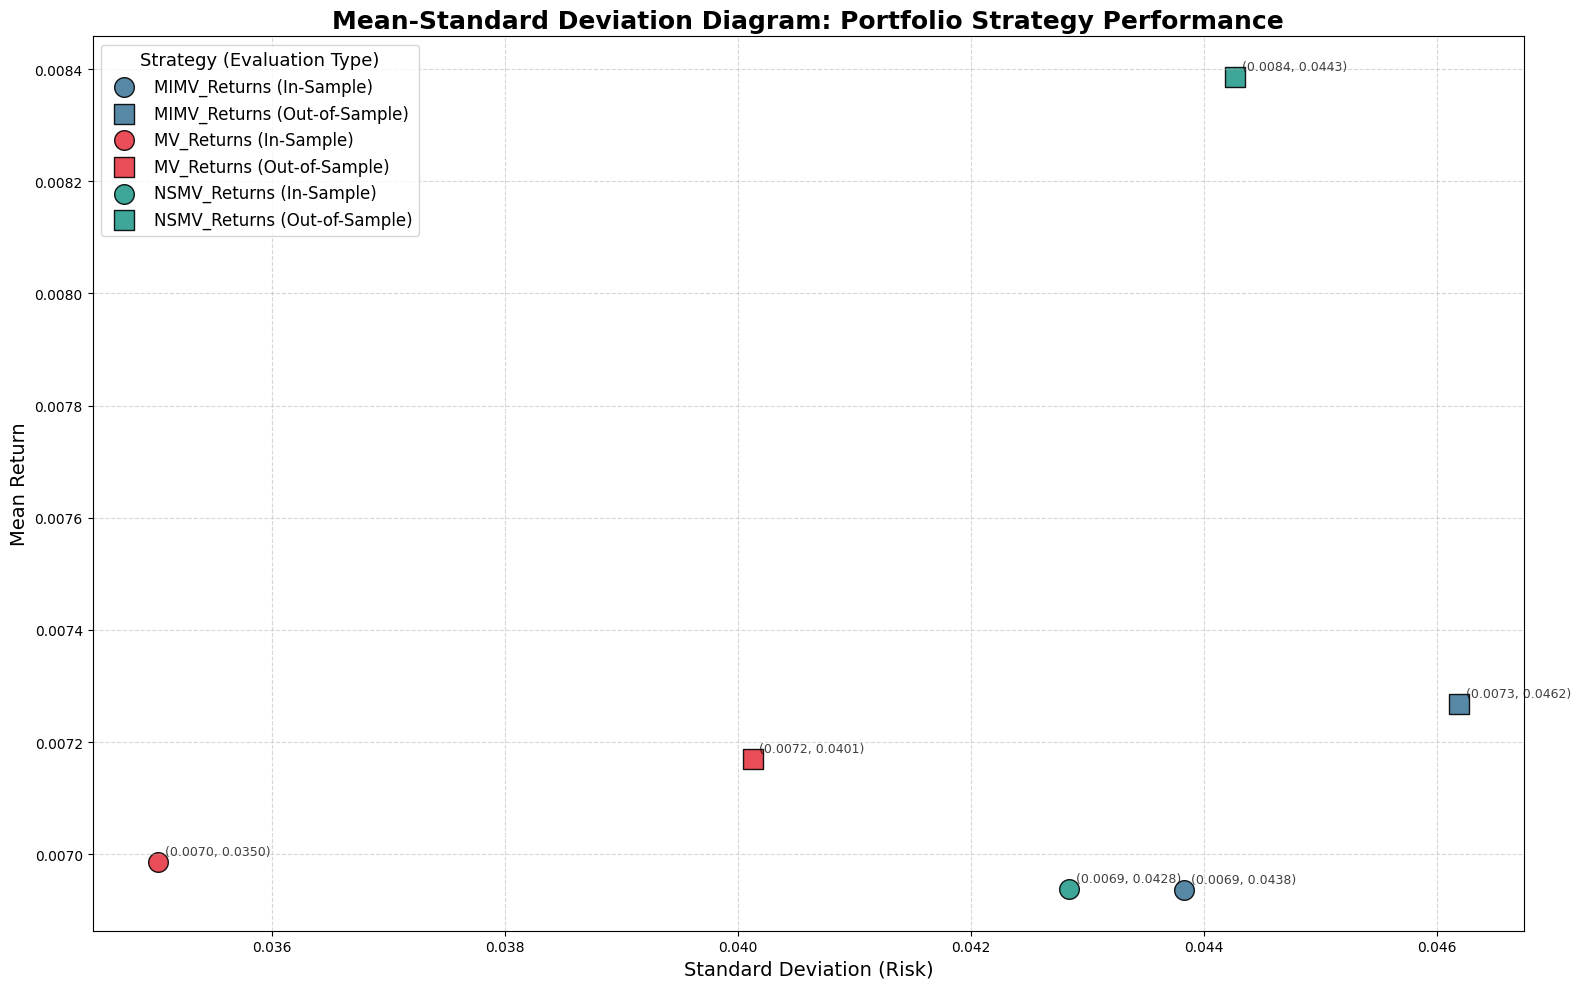

In [ ]:
# ----------------------------- Task 6 -----------------------------
# Question:
# Compute the sample mean and sample variance of returns for each strategy (NSMV, MV, and MIMV)
# using both the in- and out-of-sample evaluation method.
# This will yield 6 realized mean-variance pairs.
# Show these pairs both in tabular form and on a mean-standard deviation diagram.
# -----------------------------------------------------------------

# Import necessary libraries
import matplotlib.pyplot as plt           # For creating plots and visualizations
import seaborn as sns                     # Optional: Enhances the look of matplotlib plots
import pandas as pd                       # For working with data in tabular (DataFrame) format
import numpy as np                        # For numerical computations

# Initialize an empty list to hold data for plotting and tabulation
plot_data = []

# -------------------------- In-Sample Computation --------------------------

# Compute the mean of each strategy's returns from the full sample (in-sample)
in_sample_means = portfolio_returns_df.mean()

# Compute the variance of each strategy's returns from the full sample
in_sample_vars = portfolio_returns_df.var()

# Compute the standard deviation (square root of variance) of each strategy
in_sample_stds = portfolio_returns_df.std()

# Loop over each strategy to append its in-sample metrics to the plot_data list
for strategy in in_sample_means.index:
    plot_data.append({
        'Strategy': strategy,                        # Strategy name (e.g., MV_Returns)
        'Type': 'In-Sample',                         # Evaluation type
        'Window (M)': 'N/A',                         # Not applicable for in-sample
        'Mean': in_sample_means[strategy],           # Mean return
        'Variance': in_sample_vars[strategy],        # Variance of returns
        'Std Dev': in_sample_stds[strategy]          # Standard deviation of returns
    })

# ------------------------ Out-of-Sample Computation ------------------------

# Loop over each rolling window and its corresponding result DataFrame
for window, df in results.items():
    oos_means = df.mean()        # Compute mean of returns for each strategy in this window
    oos_vars = df.var()          # Compute variance of returns
    oos_stds = df.std()          # Compute standard deviation of returns

    # Append each strategy's metrics to the plot_data list
    for strategy in oos_means.index:
        plot_data.append({
            'Strategy': strategy,                    # Strategy name
            'Type': 'Out-of-Sample',                 # Evaluation type
            'Window (M)': window,                    # Rolling window size used
            'Mean': oos_means[strategy],             # Mean return
            'Variance': oos_vars[strategy],          # Variance
            'Std Dev': oos_stds[strategy]            # Standard deviation
        })

# ----------------------------- Create DataFrame -----------------------------

# Convert the list of dictionaries into a structured DataFrame
plot_df = pd.DataFrame(plot_data)

# ----------------------------- Display Table -----------------------------

# Print heading for the table
print("\n--- Realized Mean, Variance, and Std Dev (In-Sample & Out-of-Sample) ---")

# Set Pandas options to display full width and all columns
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

# Print the table rounded to 6 decimal places
print(plot_df.round(6))

# Reset display options back to default
pd.reset_option('display.width')
pd.reset_option('display.max_columns')

# ----------------------------- Define Plot Styles -----------------------------

# Set unique color for each strategy for consistent coloring across plot
strategy_colors = {
    'MV_Returns': '#E63946',    # Red for MV strategy
    'NSMV_Returns': '#2A9D8F',  # Teal for U strategy (Non-shrinkage MV)
    'MIMV_Returns': '#457B9D'   # Blue for MIMV strategy
}

# Define marker shapes to distinguish in-sample from out-of-sample
type_markers = {
    'In-Sample': 'o',   # Circle marker for in-sample
    'Out-of-Sample': 's' # Square marker for out-of-sample
}

# ----------------------------- Create Scatter Plot -----------------------------

# Create a new figure with specified size
plt.figure(figsize=(16, 10))

# Group the data by strategy and evaluation type to control marker and color
for (strategy, eval_type), group_df in plot_df.groupby(['Strategy', 'Type']):
    # Plot each group with corresponding color and marker
    plt.scatter(
        group_df['Std Dev'],                              # x-axis: risk
        group_df['Mean'],                                 # y-axis: return
        label=f"{strategy} ({eval_type})",                # Legend label
        color=strategy_colors.get(strategy, '#000000'),   # Fallback to black if missing
        marker=type_markers.get(eval_type, 'o'),          # Marker based on eval type
        edgecolor='black',                                # Border color for better contrast
        s=200,                                            # Marker size
        alpha=0.9                                         # Marker opacity
    )

# Annotate each point with its actual (mean, std dev) coordinates
for idx, row in plot_df.iterrows():
    plt.annotate(
        f"({row['Mean']:.4f}, {row['Std Dev']:.4f})",     # Label text
        (row['Std Dev'], row['Mean']),                    # Position on plot
        textcoords="offset points",                       # Position relative to point
        xytext=(5,5),                                     # Offset in pixels
        ha='left',                                        # Horizontal alignment
        fontsize=9,
        color='black',
        alpha=0.75
    )

# Add main title
plt.title('Mean-Standard Deviation Diagram: Portfolio Strategy Performance',
          fontsize=18, weight='bold')

# Label x-axis and y-axis
plt.xlabel('Standard Deviation (Risk)', fontsize=14)
plt.ylabel('Mean Return', fontsize=14)

# Add light grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Display legend with title and formatting
plt.legend(title='Strategy (Evaluation Type)',
           fontsize=12, title_fontsize=13, loc='best', frameon=True)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the final plot
plt.show()
